In [15]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader, random_split

In [16]:
#prepare dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_data = datasets.ImageFolder(root='./covid-dataset/train', transform=transform)
test_data = datasets.ImageFolder(root='./covid-dataset/test', transform=transform)


In [17]:
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=True)

In [18]:
for i, (X_train, y_train) in enumerate(train_data):
    if i == 8:
        break

torch.Size([1, 10, 124, 124])


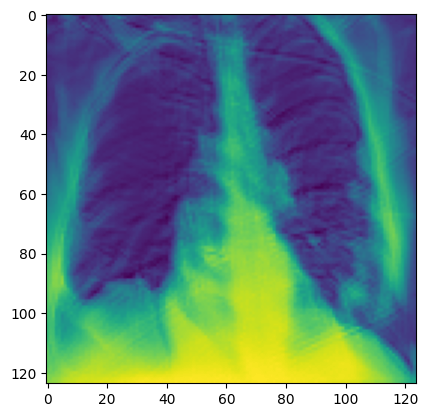

In [48]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, stride=1)

X_train.shape
# plt.imshow(X_train.view((128,128)))

x = X_train.view((1,1,128,128))
x = F.relu(conv1(x))
# x = F.max_pool2d(x, 2,2)
x = F.relu(conv2(x))
# x = F.max_pool2d(x, 2,2)
print(x.shape)

plt.imshow(x.detach().numpy()[0][3])


In [20]:
#creating model
class CovidNN(nn.Module):
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        
        #nn
        self.fc1 = nn.Linear(16*30*30, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2,2)
        
        x = x.view(x.size(0),-1)

        #nn
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [21]:
torch.manual_seed(42)
model = CovidNN()
model

CovidNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=14400, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=3, bias=True)
)

In [22]:
#set loss and optimizers

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
import time
start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for  i, (x_train, y_train) in enumerate(train_loader):
        i+=1
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr +=batch_corr

        # update parameters of model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print(f'epoch: {epoch+1}, Batch:{i}, Loss: {loss.item()}')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)


    #test the model
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            y_val = model(x_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total_time = current_time-start_time
print(f"Training took: {total_time/60} minutes!")

epoch: 1, Batch:10, Loss: 1.3787355422973633
epoch: 1, Batch:20, Loss: 0.8994695544242859
epoch: 1, Batch:30, Loss: 3.502366542816162
epoch: 1, Batch:40, Loss: 0.689470648765564
epoch: 1, Batch:50, Loss: 1.0897554159164429
epoch: 2, Batch:10, Loss: 0.6078542470932007
epoch: 2, Batch:20, Loss: 0.31115809082984924
epoch: 2, Batch:30, Loss: 0.2436898648738861
epoch: 2, Batch:40, Loss: 0.7211956977844238
epoch: 2, Batch:50, Loss: 0.546432375907898
epoch: 3, Batch:10, Loss: 0.3357018828392029
epoch: 3, Batch:20, Loss: 0.040906406939029694
epoch: 3, Batch:30, Loss: 0.1737225353717804
epoch: 3, Batch:40, Loss: 0.6936431527137756
epoch: 3, Batch:50, Loss: 0.15673625469207764
epoch: 4, Batch:10, Loss: 0.17700251936912537
epoch: 4, Batch:20, Loss: 0.0868460088968277
epoch: 4, Batch:30, Loss: 0.4411715567111969
epoch: 4, Batch:40, Loss: 0.1648567020893097
epoch: 4, Batch:50, Loss: 0.6277682781219482
epoch: 5, Batch:10, Loss: 0.03319966048002243
epoch: 5, Batch:20, Loss: 0.0073055243119597435
epoc

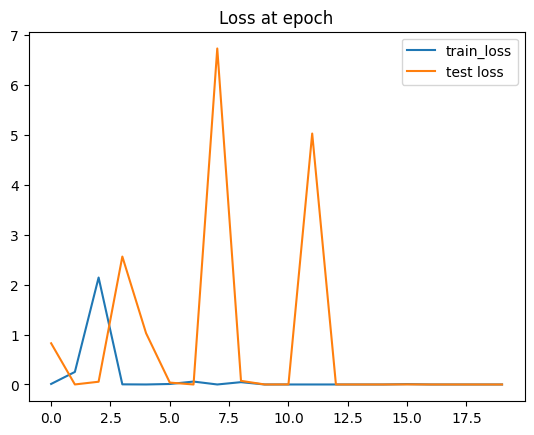

In [24]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = 'train_loss')
plt.plot(test_losses, label = 'test loss')
plt.title("Loss at epoch")
plt.legend()

Normal


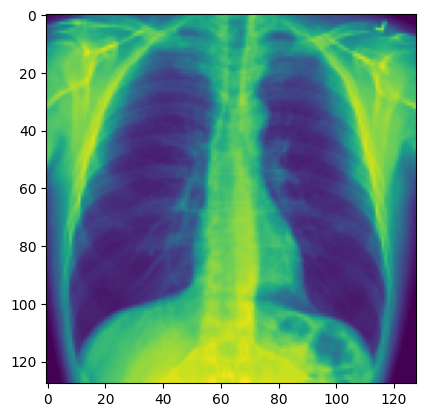

In [25]:
path_to_file = input('give image url: ')
with Image.open(path_to_file) as img:
    img = transform(img).view((1,1,128,128))

    plt.imshow(img.view((128,128)))
    model.eval()
    with torch.no_grad():
            new_pred = model(img)
    new_pred

    results = ['Covid', 'Normal', 'Viral Pneumania']
    print(results[new_pred.argmax()])

In [26]:
# loading model
torch.save(model.state_dict(), 'xRayCNN.pt')
